In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUS

In [2]:
# If running on Kaggle/Colab, these are usually present already
# !pip install torch torchvision

import os, glob, random, math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [3]:
DATA_DIR = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"  # adjust if needed
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 200
LR = 1e-3
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
DEVICE


'cuda'

In [4]:
class BUSIDataset(Dataset):
    """
    Loads only 'benign' and 'malignant' (they have masks).
    Resizes to IMG_SIZE, returns (C,H,W) tensors: image in [-1,1], mask in {0,1}.
    """
    def __init__(self, root_dir, size=(256,256), augment=False):
        self.size = size
        self.augment = augment
        self.images, self.masks = [], []

        for cls in ["benign", "malignant"]:
            for img_path in glob.glob(os.path.join(root_dir, cls, "*.png")):
                if img_path.endswith("_mask.png"):
                    continue
                mask_path = img_path[:-4] + "_mask.png"  # same name + _mask
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.masks.append(mask_path)

        self.t_img = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),                  # [0,1]
            transforms.Normalize([0.5], [0.5])      # -> [-1,1]
        ])
        self.t_mask = transforms.Compose([
            transforms.Resize(size, interpolation=Image.NEAREST),
            transforms.ToTensor()                   # [0,1]
        ])

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("L")
        mask = Image.open(self.masks[idx]).convert("L")

        # simple paired augments
        if self.augment and random.random() < 0.5:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        if self.augment and random.random() < 0.5:
            img = transforms.functional.vflip(img)
            mask = transforms.functional.vflip(mask)

        img = self.t_img(img)
        mask = self.t_mask(mask)
        mask = (mask > 0.5).float()                # binarize

        return img, mask


In [5]:
dataset = BUSIDataset(DATA_DIR, size=IMG_SIZE, augment=True)
n = len(dataset)
train_ds, val_ds = random_split(dataset, [int(0.8*n), n-int(0.8*n)],
                                generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

# (Optional) estimate positive pixel ratio on a few batches to set pos_weight
def estimate_pos_weight(loader, iters=8):
    tot_pos, tot = 0, 0
    for i, (_, m) in enumerate(loader):
        if i >= iters: break
        tot_pos += m.sum().item()
        tot += m.numel()
    pos_ratio = max(tot_pos / tot, 1e-6)
    # pos_weight for BCEWithLogitsLoss is ratio of negative/positive
    return (1 - pos_ratio) / pos_ratio

est_pw = estimate_pos_weight(train_loader, iters=10)
print(f"Estimated pos_weight ~= {est_pw:.2f}")


Train: 517, Val: 130
Estimated pos_weight ~= 9.87


In [6]:
def dice_coeff(pred_bin, target, eps=1e-6):
    # pred_bin, target: float tensors in {0,1}, shape (B,1,H,W)
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

def iou_score(pred_bin, target, eps=1e-6):
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1, bias=True),
                                 nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1, bias=True),
                                 nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1, bias=True),
                                 nn.BatchNorm2d(1),
                                 nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: decoder feature (gating), x: encoder skip
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        self.e1 = ConvBlock(in_ch, base)          # 32
        self.e2 = ConvBlock(base, base*2)         # 64
        self.e3 = ConvBlock(base*2, base*4)       # 128
        self.e4 = ConvBlock(base*4, base*8)       # 256

        # Bottleneck
        self.bottleneck = ConvBlock(base*8, base*16)  # 512

        # Decoder + Attention
        self.up4  = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.att4 = AttentionGate(base*8, base*8, base*4)
        self.d4   = ConvBlock(base*16, base*8)

        self.up3  = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.att3 = AttentionGate(base*4, base*4, base*2)
        self.d3   = ConvBlock(base*8, base*4)

        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.att2 = AttentionGate(base*2, base*2, base)
        self.d2   = ConvBlock(base*4, base*2)

        self.up1  = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.att1 = AttentionGate(base, base, base//2)
        self.d1   = ConvBlock(base*2, base)

        self.out  = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        s1 = self.e1(x)
        s2 = self.e2(self.pool(s1))
        s3 = self.e3(self.pool(s2))
        s4 = self.e4(self.pool(s3))

        b  = self.bottleneck(self.pool(s4))

        d4 = self.up4(b)
        s4a = self.att4(d4, s4)
        d4 = self.d4(torch.cat([d4, s4a], dim=1))

        d3 = self.up3(d4)
        s3a = self.att3(d3, s3)
        d3 = self.d3(torch.cat([d3, s3a], dim=1))

        d2 = self.up2(d3)
        s2a = self.att2(d2, s2)
        d2 = self.d2(torch.cat([d2, s2a], dim=1))

        d1 = self.up1(d2)
        s1a = self.att1(d1, s1)
        d1 = self.d1(torch.cat([d1, s1a], dim=1))

        # logits (no sigmoid) -> better for BCEWithLogitsLoss
        return self.out(d1)


In [9]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2 * (probs * targets).sum(dim=(1,2,3)) + self.eps
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.eps
        return 1 - (num / den).mean()

def make_criterion(pos_weight=1.0, dice_weight=1.0, bce_weight=1.0):
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=DEVICE))
    dice = DiceLoss()
    def loss_fn(logits, targets):
        return bce_weight*bce(logits, targets) + dice_weight*dice(logits, targets)
    return loss_fn

criterion = make_criterion(pos_weight=float(min(max(est_pw, 1.0), 20.0)),  # clamp a bit
                           dice_weight=1.0, bce_weight=1.0)


In [10]:
def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0.0
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE, non_blocking=True), masks.to(DEVICE, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    return total_loss / max(1, len(loader))

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, dices, ious = 0.0, [], []
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE, non_blocking=True), masks.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        loss = criterion(logits, masks)
        total_loss += loss.item()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        dices.append(dice_coeff(preds, masks))
        ious.append(iou_score(preds, masks))
    return total_loss / max(1, len(loader)), float(np.mean(dices)), float(np.mean(ious))


In [11]:
history = {"train_loss": [], "val_loss": [], "val_dice": [], "val_iou": []}

model = AttentionUNet(in_ch=1, out_ch=1, base=32).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

best_dice, best_state = 0.0, None
for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_dice, va_iou = evaluate(model, val_loader, criterion)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_dice"].append(va_dice)
    history["val_iou"].append(va_iou)

    if va_dice > best_dice:
        best_dice = va_dice
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d}: train_loss={tr_loss:.4f} val_loss={va_loss:.4f} Dice={va_dice:.4f} IoU={va_iou:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)
print("Best Dice:", best_dice)

Epoch 01: train_loss=2.0961 val_loss=2.0439 Dice=0.1750 IoU=0.1057
Epoch 02: train_loss=1.8732 val_loss=1.8808 Dice=0.2730 IoU=0.1754
Epoch 03: train_loss=1.8418 val_loss=1.8551 Dice=0.3778 IoU=0.2644
Epoch 04: train_loss=1.7293 val_loss=3.3412 Dice=0.0000 IoU=0.0000
Epoch 05: train_loss=1.7002 val_loss=1.9467 Dice=0.3466 IoU=0.2478
Epoch 06: train_loss=1.6508 val_loss=1.6547 Dice=0.3883 IoU=0.2674
Epoch 07: train_loss=1.6109 val_loss=1.6523 Dice=0.2699 IoU=0.1769
Epoch 08: train_loss=1.6301 val_loss=2.4832 Dice=0.1842 IoU=0.1120
Epoch 09: train_loss=1.5797 val_loss=1.6773 Dice=0.3419 IoU=0.2393
Epoch 10: train_loss=1.5660 val_loss=3.2778 Dice=0.1243 IoU=0.0992
Epoch 11: train_loss=1.5142 val_loss=1.5776 Dice=0.2931 IoU=0.1955
Epoch 12: train_loss=1.4793 val_loss=1.8258 Dice=0.3914 IoU=0.2952
Epoch 13: train_loss=1.7118 val_loss=1.6253 Dice=0.2771 IoU=0.1829
Epoch 14: train_loss=1.6000 val_loss=1.5728 Dice=0.3276 IoU=0.2243
Epoch 15: train_loss=1.5842 val_loss=1.5737 Dice=0.3729 IoU=0.

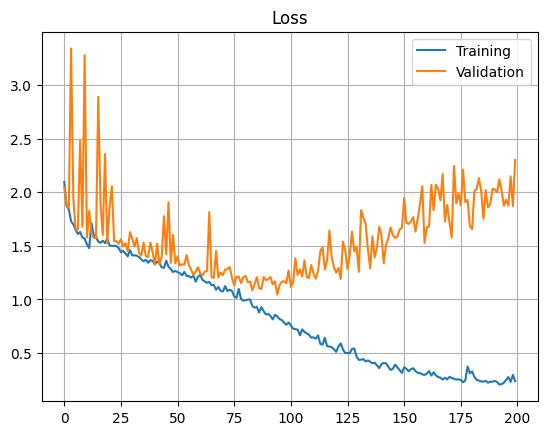

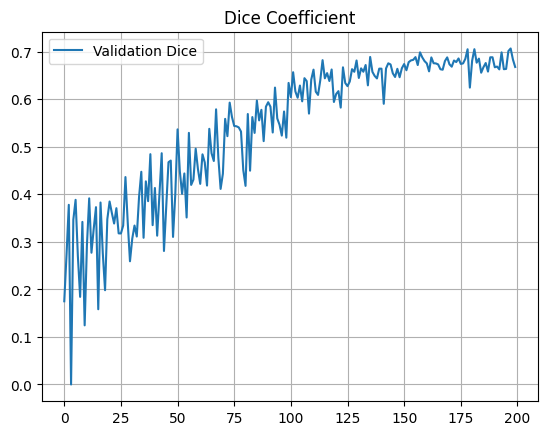

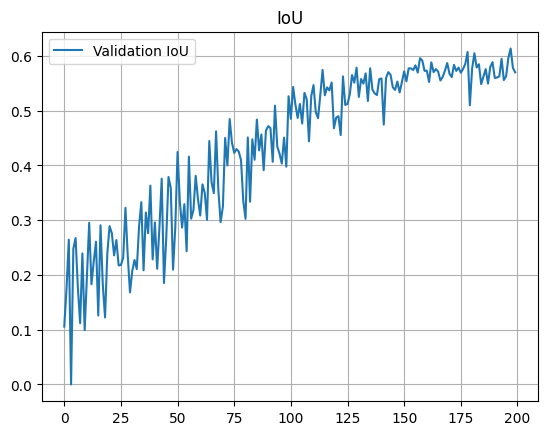

In [12]:
# Loss
plt.figure()
plt.title("Loss")
plt.plot(history["train_loss"], label="Training")
plt.plot(history["val_loss"], label="Validation")
plt.legend(); plt.grid(); plt.show()

# Dice
plt.figure()
plt.title("Dice Coefficient")
plt.plot(history["val_dice"], label="Validation Dice")
plt.legend(); plt.grid(); plt.show()

# IoU
plt.figure()
plt.title("IoU")
plt.plot(history["val_iou"], label="Validation IoU")
plt.legend(); plt.grid(); plt.show()

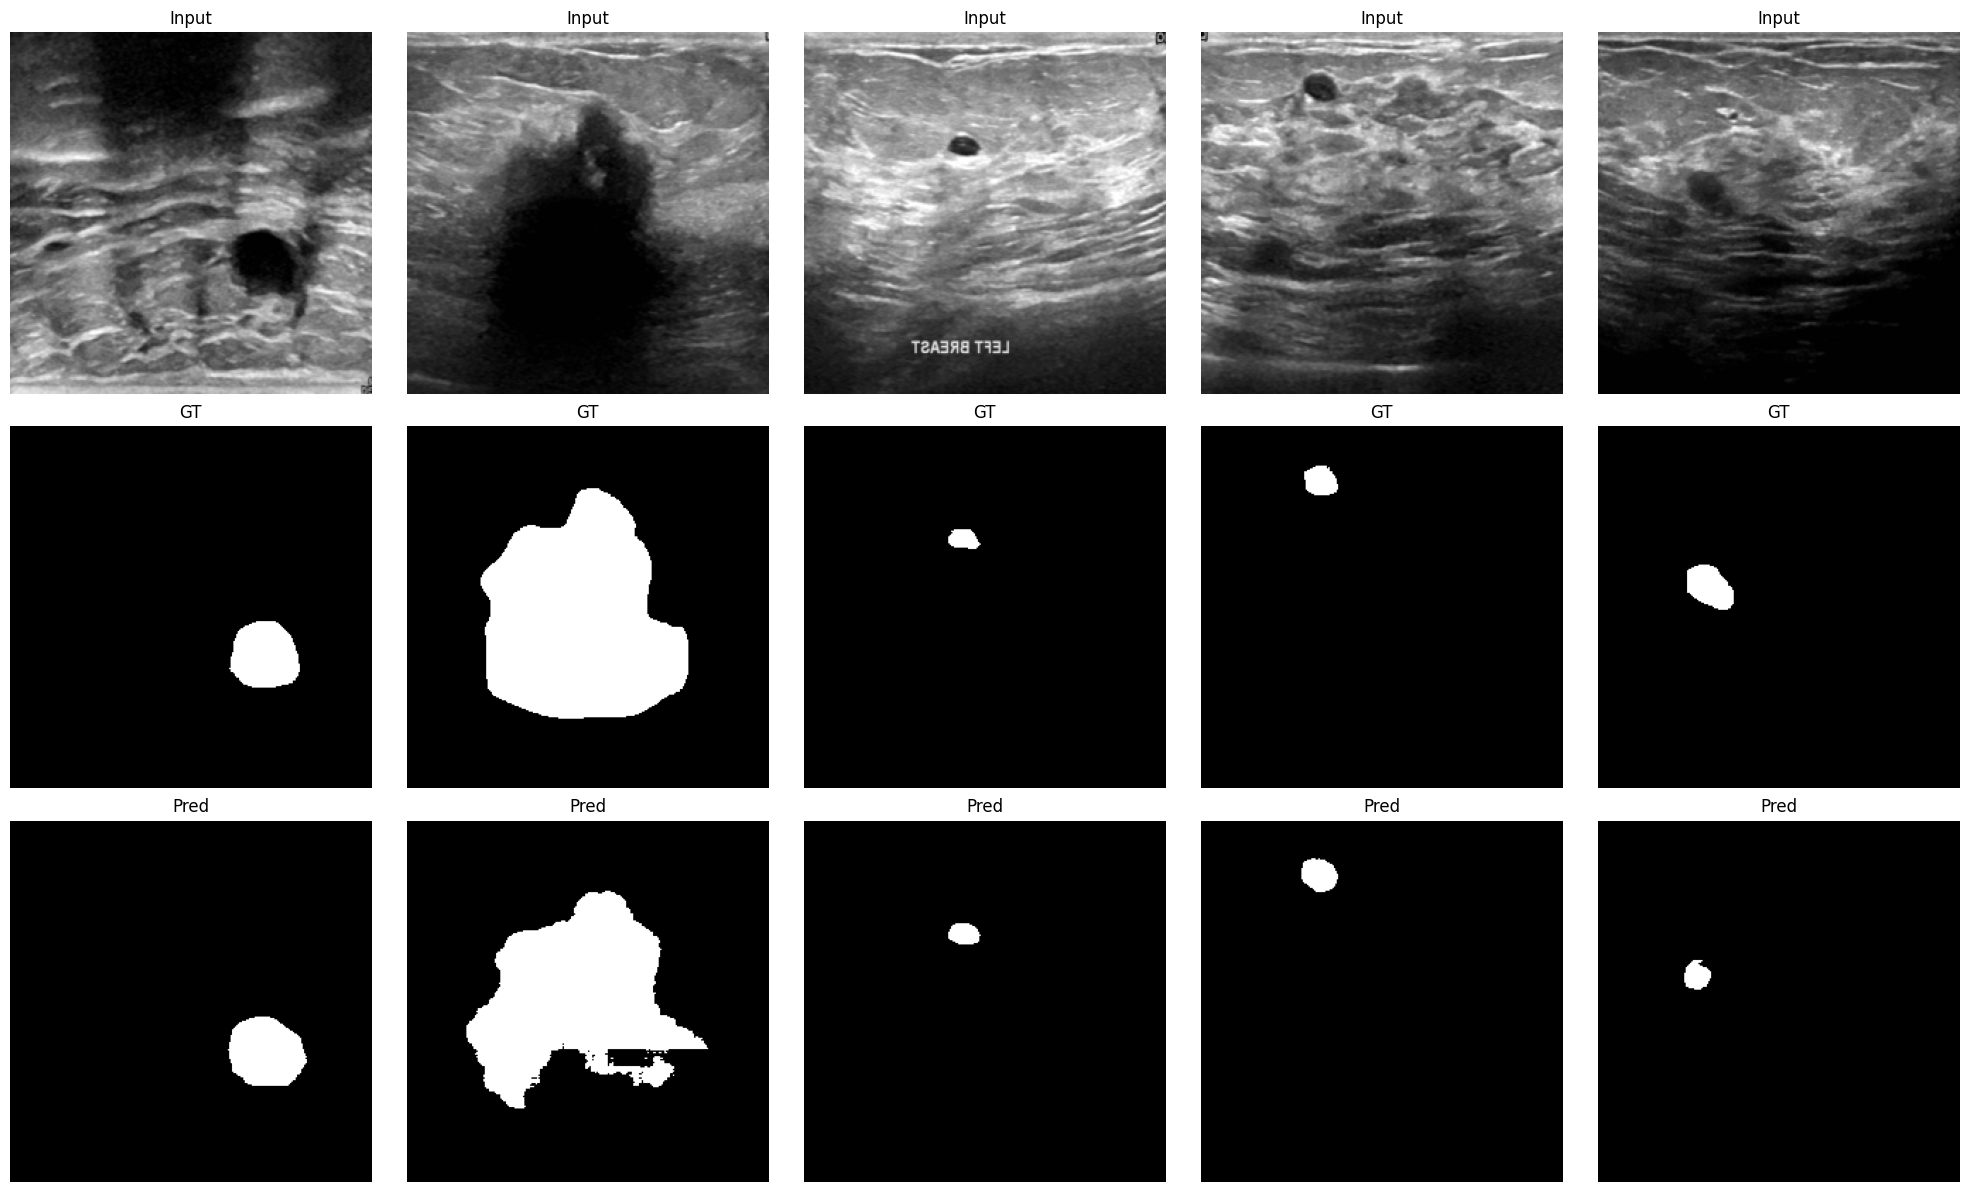

In [13]:
@torch.no_grad()
def show_samples(model, loader, n=4):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
    logits = model(imgs)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    imgs_np  = imgs.cpu().numpy()
    masks_np = masks.cpu().numpy()
    preds_np = preds.cpu().numpy()

    cols = n
    plt.figure(figsize=(4*cols, 4*3))
    for i in range(cols):
        # denorm for display
        show_img = (imgs_np[i,0] * 0.5 + 0.5)  # back to [0,1]

        plt.subplot(3, cols, 1+i); plt.imshow(show_img, cmap='gray'); plt.axis('off'); plt.title("Input")
        plt.subplot(3, cols, 1*cols + 1+i); plt.imshow(masks_np[i,0], cmap='gray'); plt.axis('off'); plt.title("GT")
        plt.subplot(3, cols, 2*cols + 1+i); plt.imshow(preds_np[i,0], cmap='gray'); plt.axis('off'); plt.title("Pred")
    plt.tight_layout(); plt.show()

show_samples(model, val_loader, n=5)


In [14]:


@torch.no_grad()
def eval_segmentation_metrics(model, loader, device="cuda", thresholds=None):
    model.eval()
    thresholds = thresholds if thresholds is not None else torch.linspace(0.1, 0.9, 9)
    thresholds = thresholds.to(device)

    # accumulators for t=0.5
    tp = fp = tn = fn = 0

    # accumulators for threshold sweep
    sweep_counts = {float(t.item()): {"tp":0, "fp":0, "tn":0, "fn":0} for t in thresholds}

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)  # (B,1,H,W) in {0,1}

        logits = model(imgs)                         # (B,1,H,W)
        probs = torch.sigmoid(logits)

        # ---- fixed threshold @ 0.5 ----
        preds = (probs > 0.5).to(masks.dtype)

        tp += (preds * masks).sum().item()
        fp += (preds * (1 - masks)).sum().item()
        fn += ((1 - preds) * masks).sum().item()
        tn += (((1 - preds) * (1 - masks))).sum().item()

        # ---- sweep thresholds ----
        for t in thresholds:
            p = (probs > t).to(masks.dtype)
            d = sweep_counts[float(t.item())]
            d["tp"] += (p * masks).sum().item()
            d["fp"] += (p * (1 - masks)).sum().item()
            d["fn"] += ((1 - p) * masks).sum().item()
            d["tn"] += (((1 - p) * (1 - masks))).sum().item()

    def compute_from_counts(tp, fp, fn, tn, eps=1e-6):
        tp, fp, fn, tn = map(float, (tp, fp, fn, tn))
        dice = (2*tp + eps) / (2*tp + fp + fn + eps)          # == F1 for positive class
        iou  = (tp + eps) / (tp + fp + fn + eps)
        prec = (tp + eps) / (tp + fp + eps)
        rec  = (tp + eps) / (tp + fn + eps)                   # sensitivity / recall
        spec = (tn + eps) / (tn + fp + eps)                   # specificity
        acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
        f1   = dice                                           # same as Dice here
        return dict(Dice=dice, IoU=iou, Precision=prec, Recall=rec,
                    Specificity=spec, Accuracy=acc, F1=f1)

    # metrics @ 0.5
    fixed_metrics = compute_from_counts(tp, fp, fn, tn)

    # metrics across thresholds + best by Dice
    sweep_metrics = {}
    best_t, best_dice = None, -1
    for t, d in sweep_counts.items():
        m = compute_from_counts(d["tp"], d["fp"], d["fn"], d["tn"])
        sweep_metrics[t] = m
        if m["Dice"] > best_dice:
            best_dice, best_t = m["Dice"], t

    return fixed_metrics, sweep_metrics, best_t, sweep_metrics[best_t]

# ---- run it ----
fixed, sweep, best_t, best_metrics = eval_segmentation_metrics(model, val_loader, device=DEVICE)

print("== Metrics @ threshold=0.5 ==")
for k, v in fixed.items():
    print(f"{k}: {v:.4f}")

print(f"\n== Best threshold by Dice: t={best_t:.2f} ==")
for k, v in best_metrics.items():
    print(f"{k}: {v:.4f}")


== Metrics @ threshold=0.5 ==
Dice: 0.7294
IoU: 0.5740
Precision: 0.7158
Recall: 0.7434
Specificity: 0.9721
Accuracy: 0.9524
F1: 0.7294

== Best threshold by Dice: t=0.80 ==
Dice: 0.7335
IoU: 0.5791
Precision: 0.7530
Recall: 0.7149
Specificity: 0.9779
Accuracy: 0.9552
F1: 0.7335


In [15]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = UNet().to(device)  # change to SimpleCNN() to compare
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.BCEWithLogitsLoss()

# for epoch in range(1, 11):
#     train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
#     val_loss, val_dice, val_iou = evaluate(model, val_loader, criterion, device)
#     print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} Dice={val_dice:.4f} IoU={val_iou:.4f}")


In [16]:
# def show_predictions(model, dataset, device, n=5):
#     model.eval()
#     plt.figure(figsize=(12, 6))
#     for i in range(n):
#         img, mask = dataset[i]
#         with torch.no_grad():
#             pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))
#             pred = (pred > 0.5).float().cpu()

#         plt.subplot(3, n, i+1)
#         plt.imshow(img[0], cmap="gray")
#         plt.title("Input")
#         plt.axis("off")

#         plt.subplot(3, n, i+1+n)
#         plt.imshow(mask[0], cmap="gray")
#         plt.title("Ground Truth")
#         plt.axis("off")

#         plt.subplot(3, n, i+1+2*n)
#         plt.imshow(pred[0,0], cmap="gray")
#         plt.title("Prediction")
#         plt.axis("off")
#     plt.show()

# # Example: visualize on validation set
# show_predictions(model, val_ds, device, n=5)


In [17]:
# after training
torch.save(model.state_dict(), "attention_unet.pth")

In [20]:
@torch.no_grad()
def eval_segmentation_metrics_both(model, loader, device="cuda", thresholds=None, eps=1e-6):
    """
    Returns:
      fixed_global   : metrics at t=0.5 computed from dataset-pooled counts
      fixed_mean     : metrics at t=0.5 averaged over images (each image equal weight)
      sweep_global   : {t: metrics} using pooled counts
      sweep_mean     : {t: metrics} using per-image averages
      best_t_global  : threshold (by global Dice)
      best_t_mean    : threshold (by mean-per-image Dice)
    """
    model.eval()
    thresholds = thresholds if thresholds is not None else torch.linspace(0.1, 0.9, 9)
    thresholds = thresholds.to(device)

    # ---- helpers ----
    def metrics_from_counts(tp, fp, fn, tn, eps=1e-6):
        tp, fp, fn, tn = map(float, (tp, fp, fn, tn))
        dice = (2*tp + eps) / (2*tp + fp + fn + eps)     # == F1 for positive class
        iou  = (tp + eps) / (tp + fp + fn + eps)
        prec = (tp + eps) / (tp + fp + eps)
        rec  = (tp + eps) / (tp + fn + eps)              # sensitivity / recall
        spec = (tn + eps) / (tn + fp + eps)              # specificity
        acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
        f1   = dice
        return dict(Dice=dice, IoU=iou, Precision=prec, Recall=rec,
                    Specificity=spec, Accuracy=acc, F1=f1)

    def metrics_from_vectors(tp, fp, fn, tn, eps=1e-6):
        # tp, fp, fn, tn are 1D tensors (per-image)
        tp = tp.float(); fp = fp.float(); fn = fn.float(); tn = tn.float()
        dice = (2*tp + eps) / (2*tp + fp + fn + eps)
        iou  = (tp + eps) / (tp + fp + fn + eps)
        prec = (tp + eps) / (tp + fp + eps)
        rec  = (tp + eps) / (tp + fn + eps)
        spec = (tn + eps) / (tn + fp + eps)
        acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
        f1   = dice
        return dict(Dice=dice, IoU=iou, Precision=prec, Recall=rec,
                    Specificity=spec, Accuracy=acc, F1=f1)

    # ---- accumulators (global) ----
    g_tp = g_fp = g_fn = g_tn = 0.0
    sweep_global_counts = {float(t.item()): {"tp":0.0, "fp":0.0, "fn":0.0, "tn":0.0} for t in thresholds}

    # ---- accumulators (per-image) ----
    # fixed t=0.5 lists
    per_img_fixed = {k: [] for k in ["Dice","IoU","Precision","Recall","Specificity","Accuracy","F1"]}
    # sweep per-image lists
    sweep_mean_lists = {
        float(t.item()): {k: [] for k in ["Dice","IoU","Precision","Recall","Specificity","Accuracy","F1"]}
        for t in thresholds
    }

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).float()    # (B,1,H,W) in {0,1}
        logits = model(imgs)
        probs  = torch.sigmoid(logits)

        # ---------- fixed threshold @ 0.5 ----------
        preds = (probs > 0.5).float()

        # vectorized per-image counts
        B = masks.shape[0]
        tp_b = (preds * masks).view(B, -1).sum(dim=1)
        fp_b = (preds * (1 - masks)).view(B, -1).sum(dim=1)
        fn_b = ((1 - preds) * masks).view(B, -1).sum(dim=1)
        tn_b = (((1 - preds) * (1 - masks))).view(B, -1).sum(dim=1)

        # global accumulate
        g_tp += tp_b.sum().item()
        g_fp += fp_b.sum().item()
        g_fn += fn_b.sum().item()
        g_tn += tn_b.sum().item()

        # per-image metrics lists (fixed t=0.5)
        m_vec = metrics_from_vectors(tp_b, fp_b, fn_b, tn_b, eps=eps)
        for k, v in m_vec.items():
            per_img_fixed[k].extend(v.detach().cpu().tolist())

        # ---------- sweep thresholds ----------
        for t in thresholds:
            p = (probs > t).float()
            tp_b = (p * masks).view(B, -1).sum(dim=1)
            fp_b = (p * (1 - masks)).view(B, -1).sum(dim=1)
            fn_b = ((1 - p) * masks).view(B, -1).sum(dim=1)
            tn_b = (((1 - p) * (1 - masks))).view(B, -1).sum(dim=1)

            # global
            d = sweep_global_counts[float(t.item())]
            d["tp"] += tp_b.sum().item()
            d["fp"] += fp_b.sum().item()
            d["fn"] += fn_b.sum().item()
            d["tn"] += tn_b.sum().item()

            # per-image
            m_vec_t = metrics_from_vectors(tp_b, fp_b, fn_b, tn_b, eps=eps)
            for k, v in m_vec_t.items():
                sweep_mean_lists[float(t.item())][k].extend(v.detach().cpu().tolist())

    # ---- finalize fixed (global & mean) ----
    fixed_global = metrics_from_counts(g_tp, g_fp, g_fn, g_tn, eps=eps)
    fixed_mean   = {k: float(np.mean(v)) for k, v in per_img_fixed.items()}

    # ---- finalize sweep (global & mean) + best thresholds ----
    sweep_global = {t: metrics_from_counts(d["tp"], d["fp"], d["fn"], d["tn"], eps=eps)
                    for t, d in sweep_global_counts.items()}
    sweep_mean   = {t: {k: float(np.mean(vals)) for k, vals in d.items()}
                    for t, d in sweep_mean_lists.items()}

    # best by Dice
    best_t_global = max(sweep_global.items(), key=lambda kv: kv[1]["Dice"])[0]
    best_t_mean   = max(sweep_mean.items(),   key=lambda kv: kv[1]["Dice"])[0]

    return fixed_global, fixed_mean, sweep_global, sweep_mean, best_t_global, best_t_mean


In [21]:
fixed_global, fixed_mean, sweep_global, sweep_mean, best_t_global, best_t_mean = \
    eval_segmentation_metrics_both(model, val_loader, device=DEVICE)

print("== Metrics @ t=0.5 (GLOBAL) ==")
for k, v in fixed_global.items():
    print(f"{k}: {v:.4f}")

print("\n== Metrics @ t=0.5 (MEAN per-image) ==")
for k, v in fixed_mean.items():
    print(f"{k}: {v:.4f}")

print(f"\nBest threshold by GLOBAL Dice: {best_t_global:.2f}")
print(f"Best threshold by MEAN Dice  : {best_t_mean:.2f}")


== Metrics @ t=0.5 (GLOBAL) ==
Dice: 0.7154
IoU: 0.5570
Precision: 0.7045
Recall: 0.7267
Specificity: 0.9712
Accuracy: 0.9501
F1: 0.7154

== Metrics @ t=0.5 (MEAN per-image) ==
Dice: 0.6720
IoU: 0.5782
Precision: 0.6819
Recall: 0.7607
Specificity: 0.9698
Accuracy: 0.9501
F1: 0.6720

Best threshold by GLOBAL Dice: 0.80
Best threshold by MEAN Dice  : 0.70
